# Lesson 3 // Text mining

---
This notebook is the first of three notebooks on the analysis of text data, or text mining. Over the three notebooks we'll look at a selection of methods for examining text data, manipulating it into different forms, and extracting insight from it. We will mainly be using the **tidytext** package in R, which in the words of the authors of the package was developed

> "... because we were familiar with many methods for data wrangling and visualization, but couldn’t easily apply these same methods to text. We found that using tidy data principles can make many text mining tasks easier, more effective, and consistent with tools already in wide use. Treating text as data frames of individual words allows us to manipulate, summarize, and visualize the characteristics of text easily and integrate natural language processing into effective workflows we were already using."

This first notebook is mainly about manipulating text data and using fairly simple summaries to extract meaning. In particular in this notebook we will:

1. Introduce "tidy" data principles and see how to make data tidy with the `gather()` and `spread()` functions from the **tidyr** package.
2. See how the **tidytext** package applies tidy data principles to text via the `unnest_tokens()` function.
3. Extract summaries from text data and examine if these are changing over time.
4. Introduce n-grams and show what the effect is of using different values of "n".
5. Build a simple text generator (a model that generates text).

The material in this workbook is based on:
* [Chapter 12](http://r4ds.had.co.nz/tidy-data.html) of R4DS, which covers tidy data and the **tidyr** package.
* [Chapter 1](http://tidytextmining.com/tidytext.html) and [Chapter 7](http://tidytextmining.com/twitter.html) of TMR. 
* Chapter 20 of [Data Science from Scratch](http://shop.oreilly.com/product/0636920033400.do) covers natural language processing, and the text generation section borrows from that chapter.

---

First load the required packages for this notebook.

In [1]:
library(tidyverse)
library(tidytext)
library(stringr)
library(lubridate)
library(wordcloud)

options(repr.plot.width=4, repr.plot.height=3) # set plot size in the notebook

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  2.1.1     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
Warning message:
“package ‘ggplot2’ was built under R version 3.5.2”Warning message:
“package ‘tibble’ was built under R version 3.5.2”Warning message:
“package ‘tidyr’ was built under R version 3.5.2”Warning message:
“package ‘purrr’ was built under R version 3.5.2”Warning message:
“package ‘dplyr’ was built under R version 3.5.2”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Loading required package: RColorBrewer


In this and the following workbooks we'll be using a dataset containing all of Donald Trump's tweets. An up-to-date archive of his tweets is maintained [here](https://github.com/bpb27/trump_tweet_data_archive) (refreshed hourly). These can be downloaded as zipped JSON files. I have stored these tweets (to 18 August 2017) as an .RData file. If you want to update the file, you can download the `condensed_20xx.json.zip` files and use the code below.  

```
library(jsonlite)

tweets <- data.frame()    
for(i in 2009:2017){
    x <- fromJSON(txt=paste0("data/condensed_",i,".json"),simplifyDataFrame = T)
    tweets <- rbind.data.frame(tweets, x)
}
rm(x)
    
save(tweets,file="data/trump-tweets.RData")    
```

We load the data, which consists of a single data frame called `tweets`, and examine the contents:

In [2]:
load("../data/trump-tweets-2018.RData")
str(tweets)

'data.frame':	33446 obs. of  8 variables:
 $ source                 : chr  "Twitter Web Client" "Twitter Web Client" "Twitter Web Client" "Twitter Web Client" ...
 $ id_str                 : chr  "6971079756" "6312794445" "6090839867" "5775731054" ...
 $ text                   : chr  "From Donald Trump: Wishing everyone a wonderful holiday & a happy, healthy, prosperous New Year. Let’s think li"| __truncated__ "Trump International Tower in Chicago ranked 6th tallest building in world by Council on Tall Buildings & Urban "| __truncated__ "Wishing you and yours a very Happy and Bountiful Thanksgiving!" "Donald Trump Partners with TV1 on New Reality Series Entitled, Omarosa's Ultimate Merger: http://tinyurl.com/yk5m3lc" ...
 $ created_at             : chr  "Wed Dec 23 17:38:18 +0000 2009" "Thu Dec 03 19:39:09 +0000 2009" "Thu Nov 26 19:55:38 +0000 2009" "Mon Nov 16 21:06:10 +0000 2009" ...
 $ retweet_count          : int  28 33 13 5 7 4 2 4 1 23 ...
 $ in_reply_to_user_id_str: chr  NA NA 

We'll start by turning the data frame into a tibble, and turning the date into a format that will be easier to work with later on. We use the `parse_datetime()` function from the **lubridate** package. The package is a Hadley Wickham one but not part of the core tidyverse. We probably won't have time to look into processing dates and times in this course, but if you are interested the relevant chapter of R4DS is [here](.http://r4ds.had.co.nz/dates-and-times.html).

In [3]:
# turn into a tibble
tweets <- as.tibble(tweets)
# parse the date
tweets <- tweets %>% mutate(date = parse_datetime(str_sub(tweets$created_at,5,30), "%b %d %H:%M:%S %z %Y"))
tweets$date[1]

Warning message:
“`as.tibble()` is deprecated, use `as_tibble()` (but mind the new semantics).
This warning is displayed once per session.”

[1] "2009-12-23 17:38:18 UTC"

Once the dates and times have been appropriately parsed we can perform various operations on them. For example, below we work out the earlier and latest tweets in the dataset, and the duration of time covered by the dataset.

In [6]:
min(tweets$date)
max(tweets$date)
max(tweets$date) - min(tweets$date)

[1] "2009-05-04 18:54:25 UTC"

[1] "2018-04-19 15:48:38 UTC"

Time difference of 3271.871 days

Let's look at a few tweets:

In [7]:
set.seed(2)
sample_tweets <- tweets %>% sample_n(5) %>% select(date,text)
sample_tweets

date,text
<dttm>,<chr>
2013-09-11 00:26:54,"""@obamafraudulent: @realDonaldTrump @d18mt2 The birth certificate that you forced Obama to show is a computer generated forgery."
2015-04-18 08:49:25,"""@RealJesus33: Hey @espn, call @realDonaldTrump to handle your @BrittMcHenry situation. #firebrittmchenry http://t.co/rQkZOQ2CVX"" To harsh."
2015-11-21 20:41:20,Thank you to all law enforcement agencies for a fabulous job! #LEO #LESM #Trump2016 https://t.co/SuH1jfOQR4
2013-10-11 13:54:26,"“If it’s worth doing, it’s worth fighting for. You’ll have lots of people and obstacles in your way. Work &amp; fight to get beyond them."""
2017-07-26 11:13:28,"Senator @lisamurkowski of the Great State of Alaska really let the Republicans, and our country, down yesterday. Too bad!"


We start by plotting the number of tweets Trump has made over time. Retweets are shown in blue.

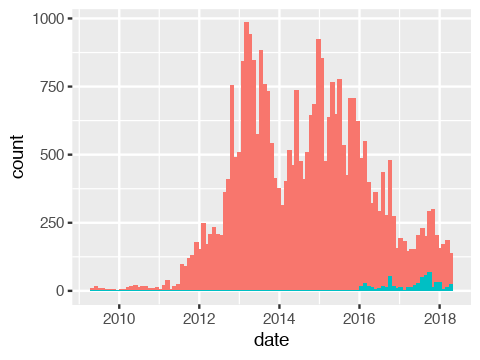

In [8]:
ggplot(tweets, aes(x = date, fill = is_retweet)) +
  geom_histogram(position = "identity", bins = 101, show.legend = FALSE)

You'll see from the few example tweets above that tweets have a particular format, but that that format is quite hard to pin down. There are special characters like `@` and `#` that mean something, some tweets have links while others do not, some are a single sentence and others are several, some mention people by name, and so on. How are we going to structure this data in a meaningful way?

To answer this question, we're going to go back a bit and talk about "tidy" data. 

## Tidy data

Tidy data is basically just a way of consistently organizing your data that often makes subsequent analysis easier, particularly if you are using **tidyverse** packages. Tidy data has three requirements:

* Each variable has its own column.
* Each observation has its own row.
* Each value has its own cell.

This only really makes sense once you work out what the variables and observations are. Of course you can't define a variable as "what's in a column", or all data will be tidy! For example, suppose we have the following data frame, containing movie ratings for 3 users and 4 movies:

In [9]:
untidy_ratings <- tribble(
  ~user_id, ~age, ~city, ~movie1, ~movie2, ~movie3,
  1, 49, "Cpt", 5, NA, NA,
  2, 20, "Cpt", 3, 3, 1, 
  3, 30, "Jhb", NA, 5, 1
)
untidy_ratings 

user_id,age,city,movie1,movie2,movie3
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,49,Cpt,5,NA,NA
2,20,Cpt,3,3,1
3,30,Jhb,NA,5,1


This data frame is not tidy because movie ratings are spread across multiple columns. 

The "tidy" way to think about this data is that the variables are the `user_id`, the user's demographic variables (`age`, `city`), the `title` of the movie, and the `rating` given. At the moment some column names (`movie1`, `movie2`, `movie3`) are actually *values* of the variable. This is a common problem with untidy data. The observations in this case are user-movie combinations.

Note that this isn't to say that "untidy" data is never useful - in fact, we used data in just the format above when building recommender systems. But there are advantages to working with tidy data, especially if you are using packages from the tidyverse.

To make the data frame tidy, we use the `gather()` function from the **tidyr** package, which provides a number of functions for getting data into (and out of) tidy format.

In [ ]:
tidy_ratings <- untidy_ratings %>% gather(movie1,movie2,movie3, key = "title", value = "rating")
tidy_ratings

This data frame shows all user-movie combinations. Those observations with no rating (because the user has not seen the movie) are given an `NA`. We say that missing values are *explicitly* represented. Another way of representing missing values is to omit the corresponding observation from the data frame. This is an *implicit* representation of a missing value. To use the implicit representation we just set `na.rm = TRUE` when using `gather()`.

In [ ]:
tidy_ratings_imp <- untidy_ratings %>% gather(movie1,movie2,movie3, key = "title", value = "rating", na.rm = TRUE)
tidy_ratings_imp

We can move back to an explicit representation of missing values using the `complete()` function. Note that we have to tell the `complete()` function that `age` and `city` do not vary over individual, and we do this using the `nesting()` command (because age and city are "nested within" user). 

In [ ]:
tidy_ratings_imp %>% complete(nesting(user_id, age, city), title)

# try these:
# tidy_ratings_imp %>% complete(c(user_id, age, city), title)  # crossed, not nested, will look for all combos
# tidy_ratings_imp %>% complete(user_id, title) # will treat like rating i.e. will have NAs

We can move in the opposite direction (spreading a variable across multiple columns) using the `spread()` function.

In [ ]:
untidy_ratings <- tidy_ratings %>% spread(key = "title", value = "rating")
untidy_ratings

Note that its not always the case that a "long" data format is tidy and a "wide" format is not. For example, the data frame below is tidy. 
```
# A tibble: 6 x 4
   town month avgtemp rainfall
  <chr> <chr>   <dbl>    <dbl>
1     A   Jan      24       12
2     B   Jan      27       10
3     C   Jan      30       16
4     A   Jun      14       22
5     B   Jun      20       62
6     C   Jun       5       16
```
but it would not be tidy if we reshape the data into a "longer" format:
```
# A tibble: 12 x 4
    town month  weather    value
   <chr> <chr>    <chr>    <dbl>
 1     A   Jan  avgtemp       24
 2     B   Jan  avgtemp       27
 3     C   Jan  avgtemp       30
 4     A   Jun  avgtemp       14
 5     B   Jun  avgtemp       20
 6     C   Jun  avgtemp        5
 7     A   Jan rainfall       32
 8     B   Jan rainfall       30
 9     C   Jan rainfall       36
10     A   Jun rainfall       22
11     B   Jun rainfall       22
12     C   Jun rainfall       16
```
There are several more examples in [Chapter 12](http://r4ds.had.co.nz/tidy-data.html) of R4DS, which covers tidy data and the **tidyr** package.

## Tidy text data

Tidy text is defined by the authors of **tidytext** as "a table with one-token-per-row" (see [Chapter 1](http://tidytextmining.com/tidytext.html) of TMR). A *token* is a whatever unit of text is meaningful for your analysis: it could be a word, a word pair, a sentence, a paragraph, a chapter, whatever. 

That means that the process of getting text data tidy is largely a matter of 

1. Deciding what the level of the analysis is going to be - what the "token" is.
2. Splitting the text into tokens, a process called *tokenization*.

We're now going to look in more detail at tokenization.

## Tokenization with `unnest_tokens()`

Tokenization is the process of splitting text up into the units that we are interested in analyzing. The `unnest_tokens()` function performs tokenization by splitting text up into the required tokens, and creating a new data frame with one token per row i.e. tidy text data.

Suppose we want to analyze the individual words Trump uses in his tweets. We do this by `unnest_tokens(tweets, word, text, token = "words")`. Note the arguments passed to `unnest_tokens()`:

* the "messy" data frame containing the text (`tweets`)
* the variable name we want to use for the tokens in the new tidy data frame (`word`)
* the variable name where the text is stored in the "messy" data frame (`text` i.e. the tweets are in `tweets$text`)
* the unit of tokenization (`token="words"`)

In [ ]:
unnest_tokens(sample_tweets, word, text, token = "words")

Let's see what happens if we tokenize by sentences:

In [ ]:
unnest_tokens(sample_tweets, sentences, text, token = "sentences") 

A really nice feature of **tidytext** is that you can tokenize by regular expressions. This gives you a lot of flexibility in deciding what you want a token to constitute. For example, for analyzing tweet data we can explicitly include symbols like `@` and `#` that mean something, and exclude symbols like `?` and `!` that don't add anything (unless we want to include them, in which case we can!).

In [ ]:
unnest_tokens(sample_tweets, word, text, token = "regex", pattern = "[^A-Za-z\\d_#@']")

We're now in a position to transform the full set of tweets into tidy text format. We'll tokenize with the regular expression we used in the last example above. 

In [ ]:
unnest_reg <- "[^A-Za-z\\d_#@']"

tidy_tweets <- tweets %>% 
  unnest_tokens(word, text, token = "regex", pattern = unnest_reg) %>%
  select(date, word, favorite_count)

Let's plot the most commonly used words:

In [ ]:
tidy_tweets %>%
  count(word, sort = TRUE) %>%
  filter(rank(desc(n)) <= 20) %>%
  ggplot(aes(reorder(word,n),n)) + geom_col() + coord_flip() + xlab("")

Not very useful! What's happening here, unsurprisingly, is that common words like "the", "to", etc are coming up most often. We can tell **tidytext** to ignore these words (which are called "stop words"). Let's have a look at a sample of stop words contained in the dictionary used by **tidytext**:

In [ ]:
sort(sample(stop_words$word,100))

There are also some words like "http" and "t" that are not stop words but that we probably don't want. We need to remove these "manually" using `str_replace_all()` with a regular expression of our choice. The regular expression below is a bit more complex that what we've used before. The basic idea is:

* `https?:` finds `http:` or `https:`.
* `.*` finds the longest match, which we don't want (why?), so we use `.*?`, which finds the *shortest* match.
* the remaining part in round brackets `([\\s]|[a-zA-Z0-9]$))` says "go till you hit a space or the end of the string".
* same applies for `www`.
* `&amp;`, `&lt;`, `&gt;` sometimes appear in the tweets to indicate `&`, `<`, `>` respectively.
* `RT` removes any retweets (we only want to look at Trump's own tweets).

We look at a few examples below. Try experiment with the input tweets and the regular expression to get a good idea of what everything does.


In [ ]:
# pattern that we want to remove (replace with nothing)
replace_reg <- "(https?:.*?([\\s]|[a-zA-Z0-9]$))|(www:.*?([\\s]|[a-zA-Z0-9]$))|&amp;|&lt;|&gt;|RT"

# tweet with a link
tweets$text[39]
str_replace_all(tweets$text[39], replace_reg, "")
# tweet with a link at end of tweet
tweets$text[2]
str_replace_all(tweets$text[2], replace_reg, "")
# tweet with a link and an &amp; 
tweets$text[15251]
str_replace_all(tweets$text[15251], replace_reg, "")

We now rerun the tokenization with these new options and again plot the most common words in the tweets:

In [ ]:
unnest_reg <- "[^A-Za-z_\\d#@']"

tidy_tweets <- tweets %>% 
    filter(!str_detect(text, "^RT")) %>% # remove retweets
    mutate(text = str_replace_all(text, replace_reg, "")) %>% # remove with a reg exp (http, www, etc)
    unnest_tokens(word, text, token = "regex", pattern = unnest_reg) %>%
    filter(!word %in% stop_words$word,str_detect(word, "[a-z]")) %>% # remove stop words
  select(date,word,favorite_count) 

We again plot the most commonly used tokens in our newly-cleaned data frame.

In [ ]:
tidy_tweets %>%
  count(word, sort = TRUE) %>%
  filter(rank(desc(n)) <= 20) %>%
  ggplot(aes(reorder(word,n),n)) + geom_col() + coord_flip() + xlab("")

It turns out Trump likes talking about himself, mostly. 

We can also see whether being president has changed the most commonly used words he uses. To do this we first create a new variable, a binary indicator of whether a tweet was made before or after Trump became president. We do this by comparing the date of the tweet to the date of the US election (8th November 2016). Note that once we have the date in a recognized format like `ymd` or `dmy`, this comparison can be trivially done.

In [ ]:
tidy_tweets <- tidy_tweets %>% mutate(is_prez = (date > ymd(20161108)))

In [ ]:
options(repr.plot.width=6, repr.plot.height=5) # make plot size bit bigger for next plots

tidy_tweets %>%
  group_by(is_prez) %>%
  count(word, sort = TRUE) %>%
  filter(rank(desc(n)) <= 20) %>%
  ggplot(aes(reorder(word,n), n, fill = is_prez)) + geom_col() + coord_flip() + xlab("")

The plot above is a bit unsatisfying - there are obviously a lot more tweets pre-presidency, and that makes it difficult to see what is happening in the post-presidency frequencies. Below we transform the absolute frequencies into relative ones and plot those (it may be helpful to break up the second code block to understand what each line does).

In [ ]:
total_tweets <- tidy_tweets %>% 
                 group_by(is_prez) %>% 
                 summarise(total = n())

In [ ]:
tidy_tweets %>%
  group_by(is_prez) %>% 
  count(word, sort = TRUE) %>% # count the number of times word used 
  left_join(total_tweets) %>% # add the total number of tweets made (pre- or post-prez)
  mutate(freq = n/total) %>% # add relative frequencies
  filter(rank(desc(freq)) < 20) %>%
  ggplot(aes(reorder(word,freq),freq,fill=is_prez)) + 
  geom_col() + 
  coord_flip() + 
    xlab("") +
  facet_grid(.~is_prez)

Below we show a wordcloud of Trump's tweets after he became president. Wordclouds are not particularly informative - they just plot words proportional to their frequency of use and position them in an attractive way. This uses the **wordcloud** package.

In [ ]:
tidy_tweets %>%
    filter(is_prez == TRUE) %>%
  count(word) %>%
  with(wordcloud(word, n, max.words = 100))

## Unigrams, bigrams, n-grams

An *n*-gram is a sequence of *n* words in a text. Unigrams are single words, bigrams are pairs of adjacent words, trigrams are sequences of three words, and so on.

The `unnest_tokens()` function allows you to easily extract n-grams using the "ngrams" token.

In [ ]:
# bigrams
unnest_tokens(sample_tweets, bigram, text, token = "ngrams", n = 2) %>% head(10)

In [ ]:
# trigrams
unnest_tokens(sample_tweets, bigram, text, token = "ngrams", n = 3) %>% head(10)

We extract the full set of bigrams below, and do the same cleaning up we did for unigrams earlier. Removing stop words is a bit trickier with bigrams. We need to separate each bigram into its constituent words, remove the stop words, and then put the bigrams back together again. Both `separate()` and `unite()` are **tidyr** functions.

In [ ]:
replace_reg <- "(https?:.*?([\\s]|[a-zA-Z0-9]$))|(www:.*?([\\s]|[a-zA-Z0-9]$))|&amp;|&lt;|&gt;|RT"

# tokenization
tweet_bigrams <- tweets %>%
  filter(!str_detect(text, "^RT")) %>%
  mutate(text = str_replace_all(text, replace_reg, "")) %>%
  unnest_tokens(bigram, text, token = "ngrams", n = 2)

# separate the bigrams 
bigrams_separated <- tweet_bigrams %>%
  separate(bigram, c("word1", "word2"), sep = " ")

# remove stop words
bigrams_filtered <- bigrams_separated %>%
  filter(!word1 %in% stop_words$word) %>%
  filter(!word2 %in% stop_words$word)

# join up the bigrams again
bigrams_united <- bigrams_filtered %>%
  unite(bigram, word1, word2, sep = " ")


We can now see what the most common bigrams are. Note that these are very different from the most common words. That is, they definitely provide different and useful information over and above what the unigrams did.

In [ ]:
bigram_counts <- bigrams_filtered %>% 
  count(word1, word2, sort = TRUE) %>% 
filter(rank(desc(n)) <= 10)
bigram_counts

# same answer (not run)
# bigrams_united %>% 
# count(bigram, sort = TRUE) %>% 
# filter(rank(desc(n)) <= 10)

## Text generation

One area of natural language processing is (natural language) *generation*, roughly speaking an attempt to generate realistic looking and sounding text and speech from some data or knowledge base. For example, one might automatically generate a short textual weather report from predicted numerical inputs.

In this section we'll build a model for generating Trump-like tweets. We do this by looking at sequences of words (or more generally *n*-grams) that Trump uses. Let's start by generating Trump-like *sentences*. We do this by:

1. Creating a dictionary of all words Trump has started a sentence with.
2. Randomly choosing one of these "start words". 
3. Identify all the instances in which he used that word, and in each case extract the "word" that followed it. A "word" can be a full stop, indicating the end of the sentence. Some words may appear more than once. Create a list with these "following words" and the frequency with which they occur on the list. 
4. To select the next word in the sentence, we choose a word from the list, either totally randomly or with probability proportional to the frequency with which each word appears on the list. 
5. Repeat steps 3 and 4 until a full stop is reached.

We still need to turn sentences into tweets - a simple way is just to generate sentences until you are out of space (140 characters).

In the previous examples full stops were included as separating characters i.e. we split a string wherever we encountered a full stop (see `unnest_reg` above, and compare below). Now we want to treat a full stop as equivalent to a word. We thus need to create a new tidy tweets data frame that does this. 

In [ ]:
unnest_reg <- "[^\\.A-Za-z_\\d#@']" # note adding a fullstop to the reg exp used before

tidy_tweets_wstop <- tweets %>% 
  filter(!str_detect(text, "^RT")) %>%
  mutate(text = str_replace_all(text, "[Dd]on't", "dont")) %>% # some additional cleaning
  mutate(text = str_replace_all(text, "(j\\.)|(J\\.)", "j")) %>% # some additional cleaning
  mutate(text = str_replace_all(text, replace_reg, "")) %>%
  mutate(text = str_replace(text, "\\.", " \\.")) %>% # add a space before fullstop so counted as own word
  unnest_tokens(word, text, token = "regex", pattern = unnest_reg) %>%
  select(id_str, date, word) %>%
  group_by(id_str) %>% # group words by tweet
  mutate(next_word = lead(word)) # the "lead" and "lag" operators can be very useful!

Let's have a look at the data frame we just constructed.

In [ ]:
head(tidy_tweets_wstop,40)

We now count the number of times that each word pair (*word* followed by *next_word*) occurs. This is the same as a bigram frequency count we did above, just that we've included full stops.

In [ ]:
transitions <- tidy_tweets_wstop %>%
  group_by(word,next_word) %>%
  count() %>% 
  ungroup() # remember to ungroup else later steps are slow!

The last full stop of every tweet is followed by an `NA`. This causes problems later on, so we replace the `NA` with another full stop.

In [ ]:
transitions$next_word[is.na(transitions$next_word)] <- "."

Finally, we unleash our unigram-based Trump tweeter. This model randomly samples from the list of next words. It continues to create sentences until the tweet is over 140 characters *and* full stop is reached. Thus the tweets it generates will be too long (more than 140 characters). As an exercise, try fixing this problem.

In [ ]:
set.seed(2)
# trump v1, unigram model, random sampling

# start at the end of a sentence (so next word is a start word)
current <- "."
result <- "."
keep_going <- TRUE
while(keep_going == TRUE){
    
    # get next word
    next_word <- transitions %>% 
    filter(word == as.character(current)) %>% 
    sample_n(1) %>% # random sampling
    select(next_word)
    
    # combine with result so far
    result <- str_c(result," ", next_word)
    current <- next_word

    # does the current word appear in the 'word' column?
    n_current <- sum(transitions$word == as.character(current))
  
    # keep going if can look up current word and tweet is < 140 or current word is not .
    keep_going <- ifelse(n_current == 0, FALSE,
                         ifelse(nchar(result) < 140, TRUE, 
                                ifelse(str_detect(current,"\\."), FALSE, TRUE)))
    
}
result

The generated tweets have traces of Trump but are more or less gibberish. We can try improve the generation model by changing the sampling to be proportional to the bigram frequency rather than random.

In [ ]:
set.seed(1)
# trump v2, unigram model, sample using transition probabilities

# start at the end of a sentence (so next word is a start word)
current <- "."
result <- "."
keep_going <- TRUE
while(keep_going == TRUE){
  
    # get next word
    next_word <- transitions %>% 
    filter(word == as.character(current)) %>% 
    sample_n(1, weight = n) %>% # proportional to count
    select(next_word)
  
    # combine with result so far
    result <- str_c(result," ", next_word)
    current <- next_word
  
  # does the current word appear in the 'word' column?
  n_current <- sum(transitions$word == as.character(current))
  
  # keep going if can look up current word and tweet is < 140 or current word is not .
  keep_going <- ifelse(n_current == 0, FALSE,
                       ifelse(nchar(result) < 140, TRUE, 
                              ifelse(str_detect(current,"\\."), FALSE, TRUE)))
  
}
result

Its hard to tell, but from a few runs it looks a little bit better but still not great. Let's see if we do any better if we look at transitions between bigrams rather than between words. As for the unigram model, we first need to add full stops, and then count how many times each transition (now between pairs of *bigrams*) occurs.

In [ ]:
# we've already lagged unigrams with full stops before, use these to create lagged bigrams
bigrams_wstop <- tidy_tweets_wstop %>% 
    filter(!is.na(word)) %>% # don't want to unite with NAs
    filter(!is.na(next_word)) %>%
    unite(bigram, word, next_word, sep = " ") %>%
    mutate(next_bigram = lead(bigram,2)) 

We now calculate the frequency count for each *bigram*-to-*next_bigram* transition. We first remove any rows where either *bigram* or *next_bigram* is missing. 

In [ ]:
# transition matrix
bigram_transitions <- bigrams_wstop %>%
    filter(!is.na(bigram)) %>% 
    filter(!is.na(next_bigram)) %>%
    group_by(bigram,next_bigram) %>%
    count() %>% 
    ungroup() # remember to ungroup else later steps are slow!

In the bigram model, a full stop is one "word" in a bigram. So we can't start with *only* a full stop, like we did before. The approach we'll take is to randomly select one of the bigrams Trump has used.

In [ ]:
set.seed(6)

# extract all starting rows
start_bigrams <- bigrams_wstop %>%
    group_by(id_str) %>%
    slice(1) %>%    # takes the first row from each tweet
    ungroup()

# choose one starting bigram
current <- start_bigrams %>%
  sample_n(1) %>% 
  select(bigram) %>% 
  as.character()

current

Finally we can put everything together to generate a tweet using the bigram model we just created.

In [ ]:
# trump v3, bigram model, sample using transition probabilities

# start with starting bigram previously generated
result <- current
keep_going <- TRUE
while(keep_going == TRUE){
  
    # get next word
    next_bigram <- bigram_transitions %>% 
    filter(bigram == as.character(current)) %>% 
    sample_n(1, weight = n) %>% 
    select(next_bigram)

    # combine with result so far
    result <- str_c(result," ", next_bigram)
    current <- next_bigram
  
    # does the current bigram appear in the bigram column?
    n_current <- sum(bigram_transitions$bigram == as.character(current))
  
  # keep going if can look up current bigram and tweet is < 140 or current bigram
  # does not contain a .
  keep_going <- ifelse(n_current == 0, FALSE,
                       ifelse(nchar(result) < 140, TRUE, 
                              ifelse(str_detect(current,"\\."), FALSE, TRUE)))
}
result

## Exercises


1. Read Section 12.1 to 12.4 of [the R4DS chapter](http://r4ds.had.co.nz/tidy-data.html) on tidy data and do the relevant exercises, in particular the ones in the ["Separating and Uniting"](http://r4ds.had.co.nz/tidy-data.html#separating-and-uniting) and ["Spreading and Gathering"](http://r4ds.had.co.nz/tidy-data.html#spreading-and-gathering) sections.

2. In this exercise we'll look at some frequency distributions in the book "Siddhartha" by Herman Hesse. We'll download the book from the [Project Gutenberg](https://www.gutenberg.org/) collection. The book we want has the Project Gutenberg ID "2500" (or pick another one you want to work with). To find the ID you need, either look on the Project Gutenberg site or, in R, we can make use of the **gutenbergr** package, which helps you download and process public domain books (see vignette [here](https://cran.r-project.org/web/packages/gutenbergr/vignettes/intro.html) for details).
```
library(gutenbergr)
gutenberg_metadata %>% filter(title == "Siddhartha")
```
We can read in the text of the book using **rvest** and convert it to a data frame for use in **tidytext**. The *text* variable contains the downloaded text (the novel *and* some additional information about Project Gutenberg, visit the link http://www.gutenberg.org/cache/epub/2500/pg2500.txt to see what is downloaded.
```
library(rvest)
sidd <- read_html("http://www.gutenberg.org/cache/epub/2500/pg2500.txt")
sidd_tidy <- data.frame(id = 1, text = html_text(html_nodes(sidd, css="body")))
```
Use `unnest_tokens()` to plot a frequency distribution of words used in the novel. Arrange the histogram so that words appear from left to right in order of their frequency of occurence. What do you find? Word frequency distributions often follow the same form, see the section of TMR on ["Zipf's law"](http://tidytextmining.com/tfidf.html#zipfs-law) for details. 
3.  Using the same data as above, and a different call to `unnest_tokens()`, plot the distribution of sentence lengths in *Siddhartha*.
4. How might you improve the tweet generator so that the sentences that it generates are not entirely independent  of one another?